In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr

from create_df_for_non_ipynb import create_dataframe
from path_util import data_path
from count_contributions import contributions_by_user, amount_detailed, avg_unique_auth_page_lengths
from visualizations import viz_scatterplot_correlation, viz_sideways, relative_positive_negative, viz_gender_target
from sum_stats import sum_up_attributes
from reading_cpsaat import read_education_data, get_major_median, read_m2021, get_major_median_annual

# 1. Overall labor market participation

In [2]:
bls_gender_race_excel_path = data_path / "bls" / "gender_race_hispanic" / "cpsaat11_gender, races, hispanic.xlsx"
gender_race_df = pd.read_excel(bls_gender_race_excel_path, skiprows = 6)

women = gender_race_df["Unnamed: 2"][0]/100
white = gender_race_df["Unnamed: 3"][0]/100
african_american = round(gender_race_df["Unnamed: 4"][0]/100, 3)
asian = gender_race_df["Unnamed: 5"][0]/100
hispanic = gender_race_df["Unnamed: 6"][0]/100

employment_dict = {"women": women, "white": white, "non_hispanic_white": white - hispanic,
                "african_american": african_american, "asian": asian, "hispanic": hispanic}
employment_dict

{'women': 0.47,
 'white': 0.775,
 'non_hispanic_white': 0.595,
 'african_american': 0.123,
 'asian': 0.066,
 'hispanic': 0.18}

# 2. Reading the data and processing

### removing missings, creating new columns, selecting only "major", ... --> ready dataframe

In [3]:
db_path = data_path / "data_bases" / "all_occupations.db"
con = sqlite3.connect(db_path)

df_all = pd.read_sql('SELECT occ_code, occ_group, occ_title, lenient_links, lenient_revs, lenient_lengths, women, white, african_american, asian, hispanic  FROM occupations', con)
df = df_all # make a copy

df = df.loc[df['women'] != "null"] # delete nulls

# fix parsing as float and rounding
for col in ["women", "white", "african_american", "asian", "hispanic"]:
    df[col] = df[col].astype(float)
    df[col] = df[col].apply(lambda x: round(x, 3))

# add a column for non-hispanic white people
if "non_hispanic_white" not in df:
    df.insert(8, "non_hispanic_white", df["white"].subtract(df["hispanic"]))

# Naive assumption that 1-women == men
if "men" not in df:
    df.insert(6, "men", (df["women"] - 1).abs())
    
print("The number of entries:", len(df))

The number of entries: 798


In [4]:
# adding the _summed corresponding values
for i in ["men", "women", "white", "non_hispanic_white", "african_american", "asian", "hispanic"]:
    new_col_name = i + "_summed"
    sum_up_attributes(i, new_col_name, df)

df_major = df.loc[df['occ_group'] == "major"] # only majors -> redundant as above code removes non-major anyways

In [5]:
articles_per_detailed = amount_detailed(df_all, df_major)
unique_auths, page_lengths, number_articles = avg_unique_auth_page_lengths(df_major)

if "art_per_detailed" not in df_major:
    df_major.insert(4, "art_per_detailed", articles_per_detailed)

if "avg_unique_auths" not in df_major:
    df_major.insert(6, "avg_unique_auths", unique_auths)
    
if "avg_art_lengths" not in df_major:
    df_major.insert(8, "avg_art_lengths", page_lengths)
    
if "amount_art" not in df_major:
    df_major.insert(4, "amount_art", number_articles)

    
df_major.head(3)

,occ_code,occ_group,occ_title,lenient_links,amount_art,art_per_detailed,lenient_revs,avg_unique_auths,lenient_lengths,avg_art_lengths,...,african_american,asian,hispanic,men_summed,women_summed,white_summed,non_hispanic_white_summed,african_american_summed,asian_summed,hispanic_summed
0,11-0000,major,Management Occupations,"[[""Certified Financial Manager"", ""http://en.wi...",18,0.473684,"{""Certified Financial Manager"": [{""revid"": 581...",406.555556,"{""Certified Financial Manager"": 2611, ""Marketi...",16922.277778,...,0.086,0.065,0.111,0.588,0.412,0.827857,0.716143,0.080143,0.065571,0.111714
73,13-0000,major,Business and Financial Operations Occupations,"[[""Loan officer"", ""http://en.wikipedia.org/?cu...",10,0.312500,"{""Loan officer"": [{""revid"": 492957605, ""user"":...",227.300000,"{""Loan officer"": 10956, ""Financial adviser"": 2...",11858.700000,...,0.105,0.086,0.103,0.503286,0.496714,0.755,0.650714,0.114429,0.092143,0.104286
129,15-0000,major,Computer and Mathematical Occupations,"[[""Information scientist"", ""http://en.wikipedi...",20,0.952381,"{""Information scientist"": [{""revid"": 329917919...",830.050000,"{""Information scientist"": 2757, ""Software deve...",16940.100000,...,0.085,0.233,0.083,0.694143,0.305857,0.684857,0.610714,0.081286,0.204429,0.074143


# 3. EDA & correlations

### 3.1. Disproportionate employment by SOC group and a given gender/race/ethnicity

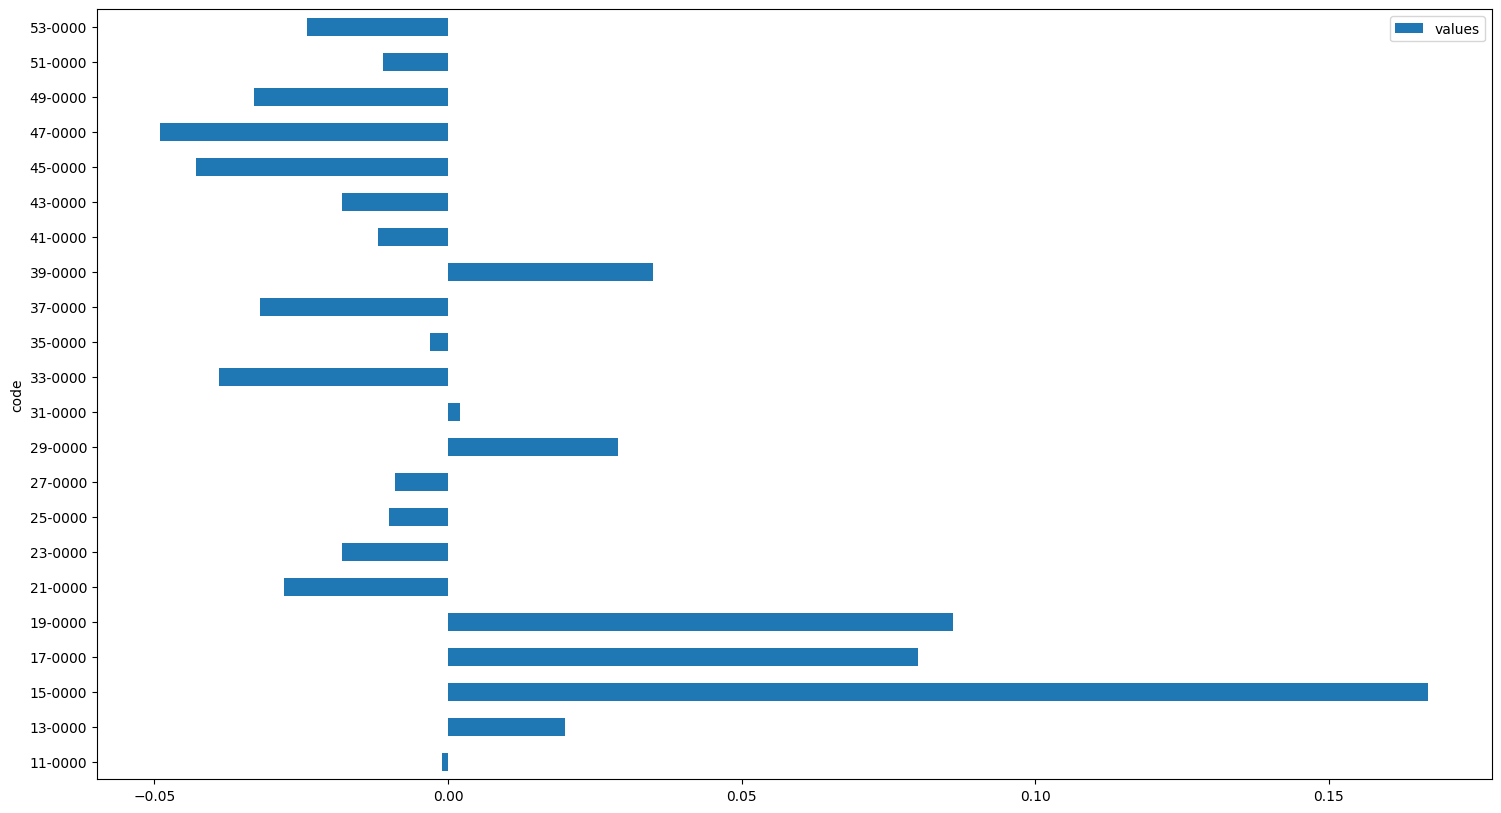

In [6]:
relative_positive_negative(df_major, "asian", employment_dict)

### 3.2. Listing all possible variables for further analysis

In [7]:
list(df_major.columns[-14:]) # all possible target_variables

['men',
 'women',
 'white',
 'non_hispanic_white',
 'african_american',
 'asian',
 'hispanic',
 'men_summed',
 'women_summed',
 'white_summed',
 'non_hispanic_white_summed',
 'african_american_summed',
 'asian_summed',
 'hispanic_summed']

In [8]:
["amount_art", "art_per_detailed", "avg_unique_auths", "avg_art_lengths"] # second variables

['amount_art', 'art_per_detailed', 'avg_unique_auths', 'avg_art_lengths']

### 3.3. Side-by-side plot of a target variable and a given metric

Choose one for each from above list

Pearsons correlation is -0.121


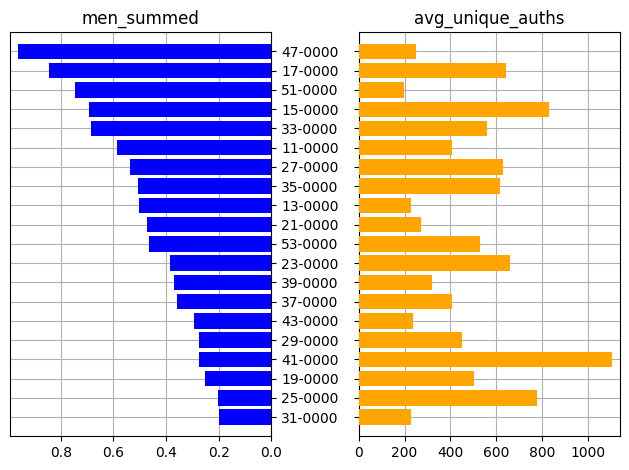

In [9]:
wiki_metric_var = "avg_unique_auths"
race_gender_var = "men_summed"

viz_sideways(df_major, race_gender_var, wiki_metric_var)

### 3.4. Scatterplot

Estimated coefficients (linear regression, RANSAC):
[-134.31592] [620.38220896]


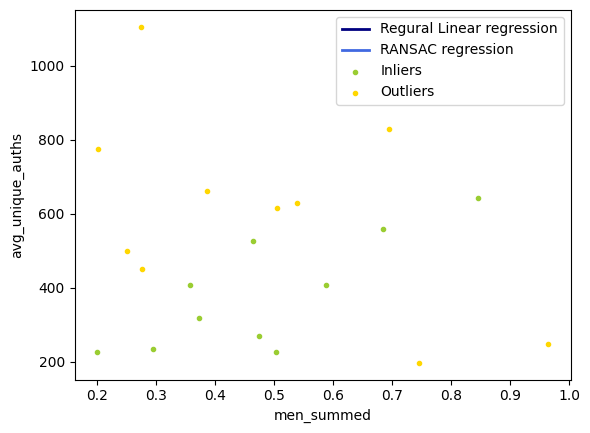

In [10]:
viz_scatterplot_correlation(df_major, race_gender_var, wiki_metric_var)


### 3.5. compare men & women

In [11]:
# viz_gender_target(df_major, race_gender_var, wiki_metric_var, "men")

# viz_gender_target(df_major, race_gender_var, wiki_metric_var, "women")

### 3.6. Correlation Matrix

##### The two alternatives for the target variables (not-summed vs summed):

In [12]:

# "men", "women", "african_american", "asian", "hispanic", "non_hispanic_white"
# "men_summed", "women_summed", "african_american_summed", "asian_summed", "hispanic_summed", "non_hispanic_white_summed"

<AxesSubplot:>

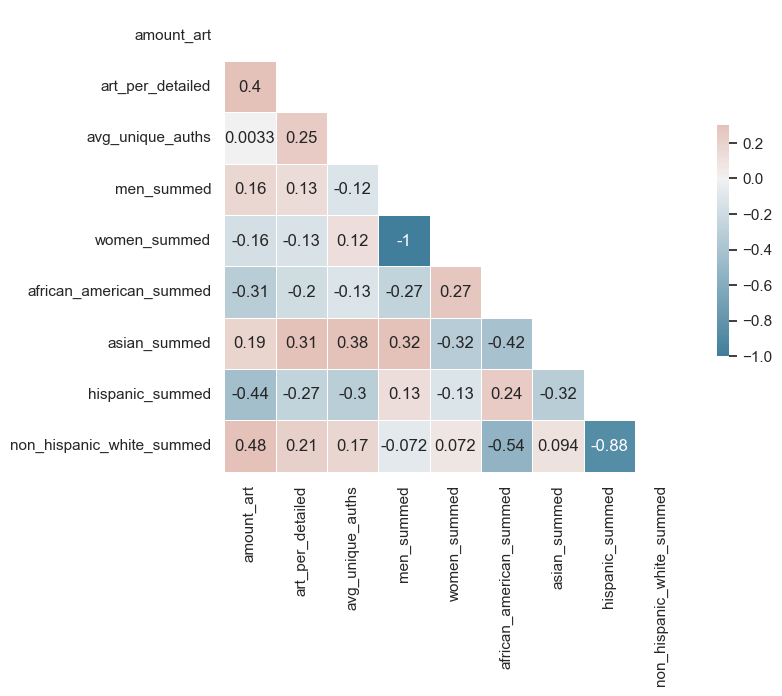

In [13]:
sns.set_theme(style="white")

corr_df = df_major[["amount_art", "art_per_detailed", "avg_unique_auths", "men_summed", "women_summed", 
                    "african_american_summed", "asian_summed", "hispanic_summed", "non_hispanic_white_summed"]].apply(pd.to_numeric)
corr_df.dropna(inplace = True)
corr = corr_df.corr(min_periods = 0)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


# 4. Control Variables

### 4.1. Adding the Mean and Median Annual Salary for each major category

In [14]:
if "A_MEAN" not in df_major:
    m_df = get_major_median_annual(read_m2021())
    df_major = df_major.set_index('occ_code').join(m_df.set_index('OCC_CODE'))
    df_major.reset_index(inplace=True) # make sure occ_code is a column and not the index
    
df_major.head()

,occ_code,occ_group,occ_title,lenient_links,amount_art,art_per_detailed,lenient_revs,avg_unique_auths,lenient_lengths,avg_art_lengths,...,hispanic,men_summed,women_summed,white_summed,non_hispanic_white_summed,african_american_summed,asian_summed,hispanic_summed,A_MEAN,A_MEDIAN
0,11-0000,major,Management Occupations,"[[""Certified Financial Manager"", ""http://en.wi...",18,0.473684,"{""Certified Financial Manager"": [{""revid"": 581...",406.555556,"{""Certified Financial Manager"": 2611, ""Marketi...",16922.277778,...,0.111,0.588,0.412,0.827857,0.716143,0.080143,0.065571,0.111714,123370,102450
1,13-0000,major,Business and Financial Operations Occupations,"[[""Loan officer"", ""http://en.wikipedia.org/?cu...",10,0.312500,"{""Loan officer"": [{""revid"": 492957605, ""user"":...",227.300000,"{""Loan officer"": 10956, ""Financial adviser"": 2...",11858.700000,...,0.103,0.503286,0.496714,0.755,0.650714,0.114429,0.092143,0.104286,82610,76570
2,15-0000,major,Computer and Mathematical Occupations,"[[""Information scientist"", ""http://en.wikipedi...",20,0.952381,"{""Information scientist"": [{""revid"": 329917919...",830.050000,"{""Information scientist"": 2757, ""Software deve...",16940.100000,...,0.083,0.694143,0.305857,0.684857,0.610714,0.081286,0.204429,0.074143,99860,97540
3,17-0000,major,Architecture and Engineering Occupations,"[[""Engineer"", ""http://en.wikipedia.org/?curid=...",15,0.416667,"{""Engineer"": [{""revid"": 194559099, ""user"": ""68...",642.666667,"{""Engineer"": 46284, ""Technologist"": 1755, ""Lan...",17190.933333,...,0.099,0.845,0.155,0.784,0.685333,0.043333,0.152333,0.098667,91740,79840
4,19-0000,major,"Life, Physical, and Social Science Occupations","[[""Conservation scientist"", ""http://en.wikiped...",19,0.395833,"{""Conservation scientist"": [{""revid"": 93806143...",500.684211,"{""Conservation scientist"": 29473, ""Biochemist""...",17686.263158,...,0.083,0.251,0.749,0.846,0.782,0.056,0.054,0.064,80730,72740


### 4.2. Adding a "slope" for the education variable

##### Slope, because it makes the consecutive regression "simpler"/less variables

In [15]:
education_lsts = get_major_median(read_education_data())

# making a df from the list of lists --> able to see each category individually
df_education = pd.DataFrame(education_lsts, columns=['o_code', 'no_high_school', 'high_school', 'some_college',
                                      'associate_degree', 'bachelors', 'masters', 'phd_professional'])

if "education_slope" not in df_major:
    slopes = []
    nums = [i for i in range(1, 8)]
    for lst in education_lsts:
        lst.pop(0)
        slope, intercept, r_value, p_value, std_err = stats.linregress(nums, lst)
        slopes.append(slope)
    df_major['education_slope'] = slopes

df_major.head(3)

,occ_code,occ_group,occ_title,lenient_links,amount_art,art_per_detailed,lenient_revs,avg_unique_auths,lenient_lengths,avg_art_lengths,...,men_summed,women_summed,white_summed,non_hispanic_white_summed,african_american_summed,asian_summed,hispanic_summed,A_MEAN,A_MEDIAN,education_slope
0,11-0000,major,Management Occupations,"[[""Certified Financial Manager"", ""http://en.wi...",18,0.473684,"{""Certified Financial Manager"": [{""revid"": 581...",406.555556,"{""Certified Financial Manager"": 2611, ""Marketi...",16922.277778,...,0.588,0.412,0.827857,0.716143,0.080143,0.065571,0.111714,123370,102450,1.425000
1,13-0000,major,Business and Financial Operations Occupations,"[[""Loan officer"", ""http://en.wikipedia.org/?cu...",10,0.312500,"{""Loan officer"": [{""revid"": 492957605, ""user"":...",227.300000,"{""Loan officer"": 10956, ""Financial adviser"": 2...",11858.700000,...,0.503286,0.496714,0.755,0.650714,0.114429,0.092143,0.104286,82610,76570,1.642857
2,15-0000,major,Computer and Mathematical Occupations,"[[""Information scientist"", ""http://en.wikipedi...",20,0.952381,"{""Information scientist"": [{""revid"": 329917919...",830.050000,"{""Information scientist"": 2757, ""Software deve...",16940.100000,...,0.694143,0.305857,0.684857,0.610714,0.081286,0.204429,0.074143,99860,97540,2.564286


### _CONTINUING after 12.9._ ... 

1. try linear robust linear models (instead of OLS) and see how they perform


2. try regressing with the control variables